# Radar chart
Plot radar charts and bar charts for IoU and VoI metrics.

Code adapated from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html. Needs manual adaptations to switch between usual charts and FloodNet.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
            # self.set_theta_zero_location('N', offset=30)

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        # outer black edges
        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)#.rotate_deg_around(.5,.5,30)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



In [3]:

def example_data(metric='iou'):
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    # data = [
    #     ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
    #     ('Basecase', [
    #         [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
    #         [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
    #         [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
    #         [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
    #         [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
    #     ('With CO', [
    #         [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
    #         [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
    #         [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
    #         [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
    #         [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
    #     ('With O3', [
    #         [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
    #         [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
    #         [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
    #         [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
    #         [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
    #     ('CO & O3', [
    #         [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
    #         [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
    #         [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
    #         [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
    #         [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    # ]
    if metric == 'iou':
        data = [
            ['Impervious', 'Building', 'Vegetation', 'Tree', 'Car', 'Clutter'],
            ('128', [
                [0.748,	0.815,	0.659,	0.662,	0.798,	0.294],
                [0.67,	0.769,	0.596,	0.547,	0.741,	0.182]]),
            ('256', [
                [0.757,	0.832,	0.661,	0.666,	0.8,	0.303],
                [0.738,	0.809,	0.63,	0.603,	0.768,	0.232]]),
            ('512', [
                [0.763,	0.844,	0.665,	0.68,	0.813,	0.315],
                [0.75,	0.833,	0.643,	0.596,	0.786,	0.218]]),
            ('1024', [
                [0.762,	0.842,	0.666,	0.676,	0.812,	0.228],
                [0.766,	0.855,	0.66,	0.63,	0.799,	0.251]]),
            ('Small', [
                [0.715,	0.764,	0.63,	0.595,	0.776,	0.234],
                [0.696,	0.727,	0.587,	0.513,	0.73,	0.215]]),
            ('IRRG', [
                [0.735,	0.804,	0.647,	0.662,	0.799,	0.262],
                [0.75,	0.813,	0.635,	0.625,	0.781,	0.248]])
        ]
    if metric == 'ppc':
        data = [
            ['Impervious', 'Building', 'Vegetation', 'Tree', 'Car', 'Clutter'],
            ('128', [
                [0.389,	0.359,	0.652,	0.638,	0.932,	0.263],
                [0.847,	0.839,	1.053,	1.008,	0.985,	0.527]]),
            ('256', [
                [0.192,	0.157,	0.384,	0.389,	0.872,	0.146],
                [0.641,	0.574,	0.887,	0.742,	0.992,	0.438]]),
            ('512', [
                [0.213,	0.182,	0.403,	0.37,	0.896,	0.219],
                [0.41,	0.505,	0.918,	0.612,	0.937,	0.258]]),
            ('1024', [
                [0.134,	0.086,	0.413,	0.36,	0.891,	0.126],
                [0.44,	0.443,	0.942,	0.481,	0.947,	0.229]]),
            ('Small', [
                [0.153,	0.092,	0.35,	0.224,	0.781,	0.112],
                [0.318,	0.255,	0.555,	0.306,	0.787,	0.183]]),
            ('IRRG', [
                [0.122,	0.053,	0.315,	0.303,	0.83,	0.122],
                [0.561,	0.475,	0.914,	0.626,	0.976,	0.345]])
        ]
        
    if metric == 'voi':
        data = [
            ['Impervious', 'Building', 'Vegetation', 'Tree', 'Car', 'Clutter'],
            ('128', [
                [0.407,0.191,0.432,0.342,0.042,0.152],
                [0.396,0.167,0.435,0.357,0.052,0.123]]),
            ('256', [
                [0.529,0.271,0.585,0.450,0.051,0.206],
                [0.494,0.238,0.563,0.487,0.059,0.173]]),
            ('512', [
                [0.633,0.324,0.670,0.512,0.054,0.268],
                [0.619,0.300,0.684,0.579,0.061,0.205]]),
            ('1024', [
                [0.700,0.379,0.747,0.566,0.059,0.257],
                [0.673,0.337,0.741,0.637,0.065,0.252]]),
            ('Small', [
                [0.715,0.440,0.746,0.574,0.064,0.266],
                [0.709,0.398,0.794,0.695,0.075,0.249]]),
            ('IRRG', [
                [0.697,0.395,0.710,0.532,0.058,0.230],
                [0.617,0.325,0.690,0.568,0.062,0.215]])
        ]
    if metric == 'false-splits':
        data = [
            ['Impervious', 'Building', 'Vegetation', 'Tree', 'Car', 'Clutter'],
            ('128', [
                [0.215,	0.110,	0.231,	0.167,	0.020,	0.075],
                [0.188,	0.080,	0.216,	0.163,	0.025,	0.041]]),
            ('256', [
                [0.270,	0.154,	0.326,	0.214,	0.025,	0.098],
                [0.239,	0.125,	0.292,	0.239,	0.031,	0.062]]),
            ('512', [
                [0.326,	0.174,	0.364,	0.237,	0.026,	0.135],
                [0.320,	0.157,	0.363,	0.271,	0.028,	0.062]]),
            ('1024', [
                [0.359,	0.199,	0.405,	0.259,	0.027,	0.087],
                [0.343,	0.173,	0.387,	0.305,	0.033,	0.086]]),
            ('Small', [
                [0.368,	0.235,	0.415,	0.252,	0.031,	0.123],
                [0.361,	0.200,	0.447,	0.346,	0.037,	0.102]]),
            ('IRRG', [
                [0.368,	0.216,	0.391,	0.248,	0.027,	0.092],
                [0.314,	0.163,	0.367,	0.276,	0.029,	0.073]])
        ]
        
    if metric == 'iou-floodnet':
        data = [
            ['Background', 	'Building\n flooded', 'Building\n non-flooded',	'Road\n flooded', 'Road\n non-flooded', 'Water', 'Tree', 'Vehicle', 'Pool',	'Grass'],
            ('512', [
                [0.015,	0.755,	0.740,	0.436,	0.770,	0.513,	0.801,	0.582,	0.540,	0.838],
                [0.004,	0.731,	0.711,	0.333,	0.784,	0.646,	0.791,	0.479,	0.565,	0.818]]),
            ('1024', [
                [0.008,	0.048,	0.364,	0.149,	0.598,	0.518,	0.744,	0.427,	0.483,	0.792],
                [0.303,	0.678,	0.677,	0.498,	0.720,	0.602,	0.790,	0.366,	0.350,	0.802]])
        ]
        
    if metric == 'floodnet':
        data = [
            ['Background', 	'Building\n flooded', 'Building\n non-flooded',	'Road\n flooded', 'Road\n non-flooded', 'Water', 'Tree', 'Vehicle', 'Pool',	'Grass'],
            ('mIoU', [
                [0.015,	0.755,	0.740,	0.436,	0.770,	0.513,	0.801,	0.582,	0.540,	0.838],
                [0.004,	0.731,	0.711,	0.333,	0.784,	0.646,	0.791,	0.479,	0.565,	0.818]]),
            ('VoI', [
                [0.020,	0.044,	0.045,	0.097,	0.095,	0.129,	0.245,	0.010,	0.011,	0.422],
                [0.016,	0.038,	0.043,	0.065,	0.079,	0.104,	0.228,	0.008,	0.010,	0.380]])
        ]
        
    if metric == 'voi-floodnet':
        data = [
            ['Background', 	'Building\n flooded', 'Building\n non-flooded',	'Road\n flooded', 'Road\n non-flooded', 'Water', 'Tree', 'Vehicle', 'Pool',	'Grass'],
            ('512', [
                [0.020,	0.044,	0.045,	0.097,	0.095,	0.129,	0.245,	0.010,	0.011,	0.422],
                [0.016,	0.038,	0.043,	0.065,	0.079,	0.104,	0.228,	0.008,	0.010,	0.380]]),
            ('1024', [
                [0.046,	0.084,	0.164,	0.102,	0.178,	0.242,	0.363,	0.020,	0.015,	0.581],
                [0.037,	0.079,	0.090,	0.088,	0.106,	0.143,	0.286,	0.019,	0.020,	0.470]])
        ]
            

    return data



In [6]:
def create_radar(N=6, data=[], save = None, metric = 'iou'):
    theta = radar_factory(N, frame='polygon')
    
    if metric == 'iou' or metric == 'iou-floodnet':
        top_title = 'Intersection over Union'
    if metric == 'ppc':
        top_title = 'Pixel per cluster ground truth rate'
    if metric == 'voi' or metric == 'voi-floodnet':
        top_title = 'Variation of Information'
    if metric == 'false-splits':
        top_title = 'False Splits'
    if metric == 'floodnet':
        top_title = ''

    data = data
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2,
                            subplot_kw=dict(projection='radar'))
    # fig, axs = plt.subplots(figsize=(12, 10), nrows=2, ncols=3,
    #                         subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.35, hspace=0.30, top=0.9, bottom=0.25)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                     # horizontalalignment='center', 
                     # verticalalignment='center'
                    )
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
            
        # plot non visible polygon to start grids at its min/max
        # ax.plot(theta, [0.9,0.9,0.9,0.1,0.1,0.1], color='w', alpha=0)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('U-Net', 'SegFormer')
    # legend = axs[0, 0].legend(labels, loc=(.95, .95),
    #                           labelspacing=0.1, fontsize='small')
    legend = axs[0].legend(labels, loc=(.95, .95),
                              labelspacing=0.1, fontsize='small')

    # fig.text(0.5, 0.965, top_title,
    #          horizontalalignment='center', color='black', weight='bold',
    #          size='large')
    fig.text(0.5, 1.03, top_title,
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    if save:
        fig.savefig(save, bbox_inches='tight')
    
    plt.show()
    return fig

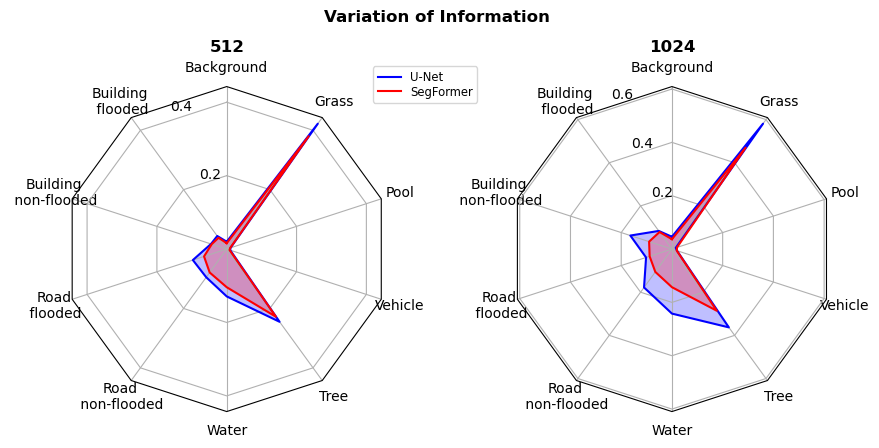

In [7]:
metric = 'voi-floodnet'
c = 10
data = example_data(metric)
saveas = '../results/radarchart_' + metric + '.png'

radar_chart = create_radar(N = c, data=data, save=saveas, metric = metric)

radar_chart.savefig('/cloud/sciebo/MasterThesis/master-thesis/figures/results/radarchart_' + metric + '.png', bbox_inches='tight')

# bar plots

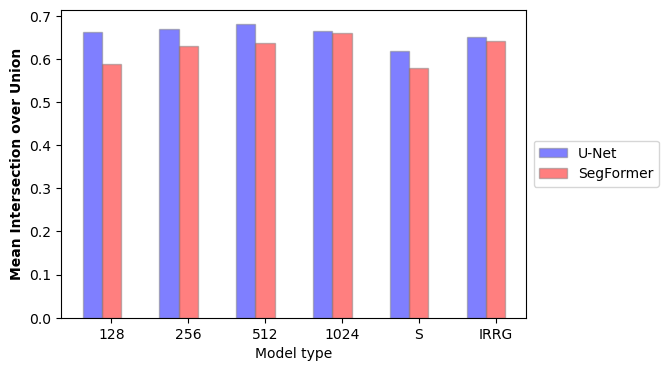

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
 
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4)) 
metric = 'miou'
    
# set height of bar 
if metric == 'voi':
    unet = [0.732,	1.000,	1.224,	1.408,	1.416,	1.321]
    segformer = [0.701,	0.938,	1.194,	1.388,	1.428,	1.206]
    y_label = 'Variation of Information'
    plt.ylabel(y_label, fontweight ='bold', labelpad = 17)#, fontsize = 15) 
    textstr = '(smaller value is better)'
    plt.text(-1.05, .4, textstr, fontsize=9, rotation='vertical')
    
if metric == 'miou':
    unet = [0.662, 0.670, 0.680, 0.664, 0.619, 0.651]
    segformer = [0.589, 0.630, 0.638, 0.660, 0.578, 0.642]
    y_label = 'Mean Intersection over Union'
    plt.ylabel(y_label, fontweight ='bold') 
    
if metric == 'miou-floodnet':
    unet = [0.599, 0.413]
    segformer = [0.586, 0.579]
    y_label = 'Mean Intersection over Union'
    plt.ylabel(y_label, fontweight ='bold') 
    
if metric == 'voi-floodnet':
    unet = [0.538,	0.802]
    segformer = [0.447,	0.630]
    y_label = 'Variation of Information'
    plt.ylabel(y_label, fontweight ='bold', labelpad = 17)#, fontsize = 15) 
    textstr = '(smaller value is better)'
    plt.text(-1.05, .4, textstr, fontsize=9, rotation='vertical')

    
if metric == 'accuracy':
    unet = [0.825, 0.831, 0.836, 0.835, 0.796, 0.820]
    segformer = [ 0.779, 0.808, 0.817, 0.831, 0.765, 0.816]
    y_label = 'Accuracy'
    plt.ylabel(y_label, fontweight ='bold') 
    
if metric == 'false-splits':
    unet = [0.387,		0.529,		0.634,		0.688,		0.725,		0.681]
    segformer = [0.318,		0.455,		0.578,		0.673,		0.735,		0.588]
    y_label = 'False Splits'
    plt.ylabel(y_label, fontweight ='bold') 
    

    
# Set position of bar on X axis 
br1 = np.arange(len(unet)) 
br2 = [x + barWidth for x in br1] 
# br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, unet, color ='b', width = barWidth, 
        edgecolor ='grey', label ='U-Net', alpha =.5) 
plt.bar(br2, segformer, color ='r', width = barWidth, 
        edgecolor ='grey', label ='SegFormer', alpha =.5) 
 
# Adding Xticks 
plt.xlabel('Model type')#, fontweight ='bold', fontsize = 15) 
# plt.ylabel(y_label, fontweight ='bold', labelpad = 17)#, fontsize = 15) 
# plt.set_ylabel(y_label, fontweight='bold', labelpad = 10)
# ylabel.set_transform(Affine2D().translate(0,.1))#.rotate_deg_around(.5,.5,30)
                                    
plt.xticks([r + barWidth for r in range(len(unet))], 
        ['128', '256', '512', '1024', 'S', 'IRRG'])
 
plt.legend(loc = 'right', bbox_to_anchor=(1.30, 0.5))

saveas = '../results/barplot_' + metric + '.png'
plt.savefig(saveas, bbox_inches='tight')
plt.savefig('/cloud/sciebo/MasterThesis/master-thesis/figures/results/barchart_' + metric + '.png', bbox_inches='tight')

plt.show() 
